# Setup

In [1]:
# نصب Java و Spark (نسخه پایدارتر برای Colab)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

# تنظیم متغیرهای محیطی
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

import findspark
findspark.init()


# **1-**

# Spark Sec

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HeartDiseaseClassification") \
    .getOrCreate()


# Dataset

## دانلود

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

print("Path to dataset files:", path)

## لود لوکال

In [ ]:
df = spark.read.csv("/content/heart_disease_uci.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: boolean (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: integer (nullable = true)
 |-- exang: boolean (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)

+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+-----------------+---+
| id|age|   sex|  dataset|             cp|trestbps|chol|  fbs|       restecg|thalch|exang|oldpeak|      slope| ca|             thal|num|
+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+--------------

# PreProcess

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna()
categorical_cols = []
numerical_cols = [col for col in df.columns if col != 'target']

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
pipeline = Pipeline(stages=[assembler])
df_transformed = pipeline.fit(df).transform(df)

df_final = df_transformed.select("features", "target")
df_final.show(5)

In [ ]:
from pyspark.sql.functions import col

# مرحله 0: تبدیل ستون‌های boolean به رشته
df = df.withColumn("fbs", col("fbs").cast("string"))
df = df.withColumn("exang", col("exang").cast("string"))

# حذف ردیف‌های ناقص
df = df.dropna()

# لیست ستون‌های دسته‌ای (categorical) که باید index بشن
categorical_cols = ["sex", "cp", "restecg", "slope", "thal", "fbs", "exang", "dataset"]

# ستون‌های عددی (numeric)
numeric_cols = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]

# مراحل index کردن
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx") for col in categorical_cols]

# ترکیب featureها
assembler = VectorAssembler(
    inputCols=[col + "_idx" for col in categorical_cols] + numeric_cols,
    outputCol="features"
)

# pipeline ساخت
pipeline = Pipeline(stages=indexers + [assembler])

# اجرا
df_prepared = pipeline.fit(df).transform(df)

# نهایی‌سازی دیتافریم
df_final = df_prepared.select("features", col("num").alias("label"))
df_final.show(5)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,3.0,1.0,2.0,...|    0|
|(14,[2,6,8,9,10,1...|    2|
|[0.0,0.0,1.0,0.0,...|    1|
|(14,[1,3,8,9,10,1...|    0|
|[1.0,2.0,1.0,1.0,...|    0|
+--------------------+-----+
only showing top 5 rows



# Train / Test : Split

In [ ]:
# تقسیم داده‌ها
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# آموزش مدل
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


rf = RandomForestClassifier(labelCol="label", featuresCol="features")
model = rf.fit(train_data)

# پیش‌بینی
predictions = model.transform(test_data)

# نمایش نتایج
predictions.select("prediction", "label").show(10)

# ارزیابی دقت
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f" Accuracy: {accuracy}")


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       2.0|    2|
|       0.0|    0|
+----------+-----+
only showing top 10 rows

✅ Accuracy: 0.6595744680851063


# Eval

In [ ]:
df_final.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   56|
|    3|   35|
|    4|   13|
|    2|   35|
|    0|  160|
+-----+-----+



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# پیش‌بینی مجدد
predictions = model.transform(test_data)

# محاسبه معیارها در PySpark
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

acc = evaluator_accuracy.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)
prec = evaluator_precision.evaluate(predictions)
rec = evaluator_recall.evaluate(predictions)

print(f" Accuracy        : {acc:.4f}")
print(f" F1 Score        : {f1:.4f}")
print(f" Precision       : {prec:.4f}")
print(f" Recall (Sensitivity): {rec:.4f}")


✅ Accuracy        : 0.6596
🎯 F1 Score        : 0.5995
🧭 Precision       : 0.5818
🧪 Recall (Sensitivity): 0.6596


🔍 Confusion Matrix:
[[29  0  0  1  0]
 [ 6  1  1  2  0]
 [ 1  0  1  0  0]
 [ 1  2  1  0  0]
 [ 0  0  1  0  0]]


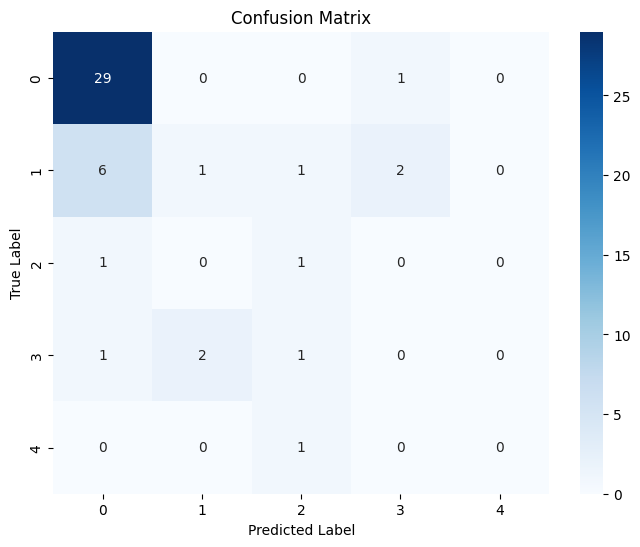

In [ ]:
# استخراج prediction و label به صورت لیست
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

# محاسبه و نمایش confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
print(" Confusion Matrix:")
print(cm)

# رسم گرافیکی
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(" Classification Report:")
print(classification_report(y_true, y_pred, digits=3))


📝 Classification Report:
              precision    recall  f1-score   support

           0      0.784     0.967     0.866        30
           1      0.333     0.100     0.154        10
           2      0.250     0.500     0.333         2
           3      0.000     0.000     0.000         4
           4      0.000     0.000     0.000         1

    accuracy                          0.660        47
   macro avg      0.273     0.313     0.271        47
weighted avg      0.582     0.660     0.599        47



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Temp to Improve

### جنگل بهتر :

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    2|
|       0.0|    0|
+----------+-----+
only showing top 10 rows

✅ Accuracy       : 0.6596
🎯 F1 Score       : 0.6150
🧭 Precision      : 0.6279
🧪 Recall         : 0.6596


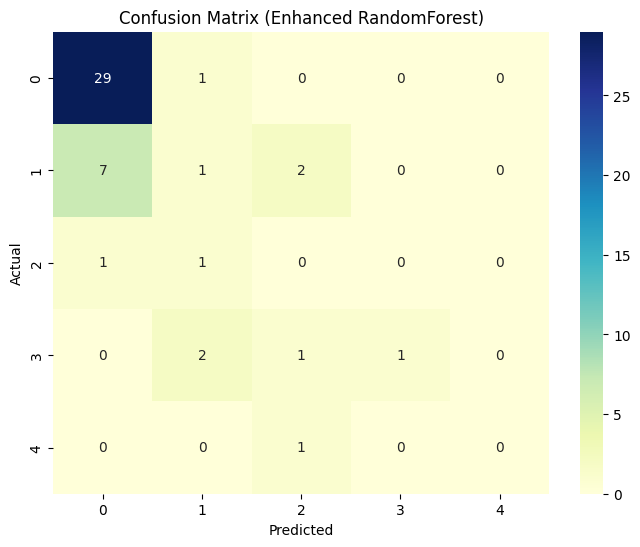

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. تقسیم داده‌ها
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# 2. مدل قوی‌تر با پارامترهای بهتر
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=200,               # درخت‌های بیشتر = مدل پایدارتر
    maxDepth=10,                # عمق بیشتر = تفکیک بهتر کلاس‌ها
    minInstancesPerNode=2,      # کنترل overfitting
    featureSubsetStrategy="auto", # انتخاب ویژگی بهینه در هر split
    subsamplingRate=0.9         # شبه-bagging برای تنوع بیشتر در درخت‌ها
)
model = rf.fit(train_data)

# 3. پیش‌بینی
predictions = model.transform(test_data)
predictions.select("prediction", "label").show(10)

# 4. ارزیابی چندمعیاری در PySpark
eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
eval_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

print(f" Accuracy       : {eval_acc.evaluate(predictions):.4f}")
print(f" F1 Score       : {eval_f1.evaluate(predictions):.4f}")
print(f" Precision      : {eval_prec.evaluate(predictions):.4f}")
print(f" Recall         : {eval_rec.evaluate(predictions):.4f}")

# 5. Confusion Matrix (با تبدیل به pandas)
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Enhanced RandomForest)")
plt.show()


محاسبه وزن کلاس معکوس نسبت به تعداد نمونه

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, count, lit, when

# محاسبه تعداد هر کلاس
label_counts = df_final.groupBy("label").count().toPandas().set_index("label")["count"].to_dict()

# ساخت weight برای هر ردیف: weight = 1 / count(label)
weight_expr = when(col("label") == 0, 1.0 / label_counts[0]) \
    .when(col("label") == 1, 1.0 / label_counts[1]) \
    .when(col("label") == 2, 1.0 / label_counts[2]) \
    .when(col("label") == 3, 1.0 / label_counts[3]) \
    .when(col("label") == 4, 1.0 / label_counts[4]) \
    .otherwise(1.0)

# اضافه کردن weightColumn
df_weighted = df_final.withColumn("class_weight", weight_expr)


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       2.0|    2|
|       0.0|    0|
+----------+-----+
only showing top 10 rows

 Accuracy       : 0.6596
 F1 Score       : 0.5979
 Precision      : 0.5570
 Recall         : 0.6596


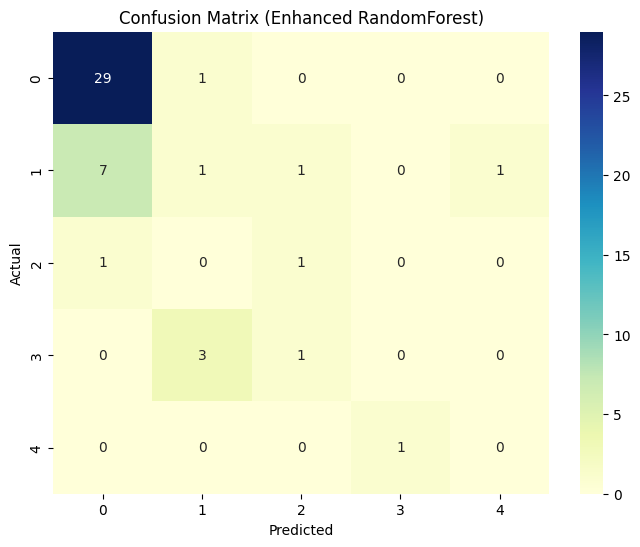

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# تقسیم با وزن
train_data, test_data = df_weighted.randomSplit([0.8, 0.2], seed=42)

# مدل با وزن‌دهی
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    weightCol="class_weight",    #  این خط اضافه شده
    numTrees=200,
    maxDepth=12,
    subsamplingRate=0.85,
    featureSubsetStrategy="auto"
)

model = rf.fit(train_data)
predictions = model.transform(test_data)

predictions.select("prediction", "label").show(10)

# 4. ارزیابی چندمعیاری در PySpark
eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
eval_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

print(f" Accuracy       : {eval_acc.evaluate(predictions):.4f}")
print(f" F1 Score       : {eval_f1.evaluate(predictions):.4f}")
print(f" Precision      : {eval_prec.evaluate(predictions):.4f}")
print(f" Recall         : {eval_rec.evaluate(predictions):.4f}")

# 5. Confusion Matrix (با تبدیل به pandas)
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Enhanced RandomForest)")
plt.show()

### شبکه عصبی MultilayerPerceptronClassifier با ساختار Pipeline

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

# ایجاد SparkSession
spark = SparkSession.builder.appName("SchemaInspection").getOrCreate()

# بارگذاری مجدد داده
df = spark.read.csv("/content/heart_disease_uci.csv", header=True, inferSchema=True)

# نمایش ساختار ستون‌ها
df.printSchema()


root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: boolean (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: integer (nullable = true)
 |-- exang: boolean (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1. شروع Spark
spark = SparkSession.builder.master("local[*]").appName("HeartDiseaseRF").getOrCreate()

# 2. بارگذاری داده
df = spark.read.csv("/content/heart_disease_uci.csv", header=True, inferSchema=True)

# 3. پاک‌سازی و پرکردن null
df = df.fillna({
    "ca": -1, "thalch": -1, "oldpeak": -1, "trestbps": -1,
    "chol": -1, "fbs": 0, "exang": 0,
    "sex": "unknown", "cp": "unknown", "restecg": "unknown",
    "slope": "unknown", "thal": "unknown", "dataset": "unknown"
})

# 4. مشخص کردن ویژگی‌ها
categorical_cols = ["sex", "cp", "restecg", "slope", "thal", "dataset"]
numerical_cols = ["age", "trestbps", "chol", "fbs", "thalch", "exang", "oldpeak", "ca"]
label_col = "num"

# 5. Index کردن ویژگی‌های متنی
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep") for col in categorical_cols]

# 6. ترکیب همه ویژگی‌ها
feature_cols = [col + "_indexed" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw", handleInvalid="keep")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")

# 7. مدل RandomForest با پارامترهای قوی‌تر
rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=200, maxDepth=10, maxBins=64)

# 8. ساخت Pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, rf])

# 9. تقسیم داده‌ها
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# 10. آموزش مدل
model = pipeline.fit(train_data)

# 11. پیش‌بینی
predictions = model.transform(test_data)

# 12. ارزیابی دقت
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# 13. نمایش متریک‌ها
print(f"\n✅ Accuracy       : {accuracy:.4f}")

# تبدیل به Pandas
y_true = predictions.select(label_col).toPandas()
y_pred = predictions.select("prediction").toPandas()

# نمایش گزارش
print("🎯 F1 Score       :", f"{classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']:.4f}")
print("🧭 Precision      :", f"{classification_report(y_true, y_pred, output_dict=True)['weighted avg']['precision']:.4f}")
print("🧪 Recall         :", f"{classification_report(y_true, y_pred, output_dict=True)['weighted avg']['recall']:.4f}")

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred))



✅ Accuracy       : 0.5973
🎯 F1 Score       : 0.5748
🧭 Precision      : 0.5640
🧪 Recall         : 0.5973

📊 Confusion Matrix:
[[52 10  2  2  0]
 [ 9 28  2  3  0]
 [ 2 12  3  2  0]
 [ 4  2  3  6  1]
 [ 1  4  1  0  0]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        66
           1       0.50      0.67      0.57        42
           2       0.27      0.16      0.20        19
           3       0.46      0.38      0.41        16
           4       0.00      0.00      0.00         6

    accuracy                           0.60       149
   macro avg       0.40      0.40      0.39       149
weighted avg       0.56      0.60      0.57       149



### Undersampling باعث از دست رفتن اطلاعات

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    1|
|       1.0|    2|
|       0.0|    1|
|       1.0|    1|
|       0.0|    1|
|       1.0|    4|
|       1.0|    2|
|       0.0|    1|
|       2.0|    2|
|       1.0|    4|
+----------+-----+
only showing top 10 rows

✅ Accuracy       : 0.2571
🎯 F1 Score       : 0.2784
🧭 Precision      : 0.3558
🧪 Recall         : 0.2571


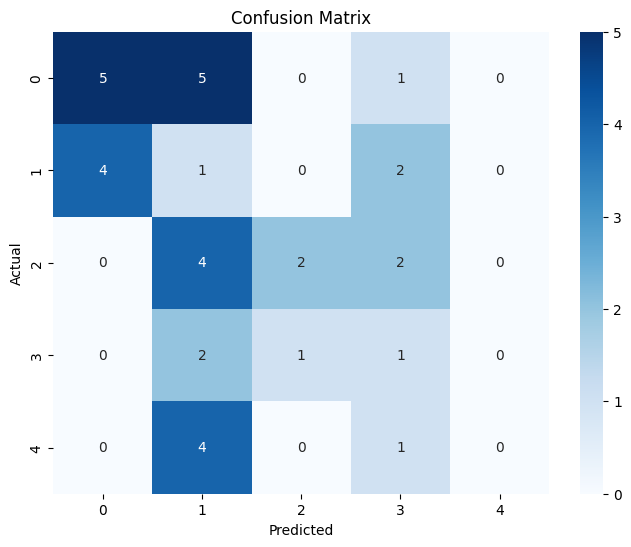


📄 Classification Report:
              precision    recall  f1-score   support

           0      0.556     0.455     0.500        11
           1      0.062     0.143     0.087         7
           2      0.667     0.250     0.364         8
           3      0.143     0.250     0.182         4
           4      0.000     0.000     0.000         5

    accuracy                          0.257        35
   macro avg      0.286     0.219     0.226        35
weighted avg      0.356     0.257     0.278        35



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. متعادل‌سازی داده‌ها: undersample کلاس 0
minor_classes = df_final.filter(col("label") != 0)
major_class_sample = df_final.filter(col("label") == 0).sample(withReplacement=False, fraction=0.35, seed=42)
balanced_df = minor_classes.union(major_class_sample)

# 2. تقسیم داده‌ها
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=42)

# 3. آموزش مدل جنگل تصادفی
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=8)
model = rf.fit(train_data)

# 4. پیش‌بینی
predictions = model.transform(test_data)
predictions.select("prediction", "label").show(10)

# 5. ارزیابی معیارهای عملکرد
eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
eval_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

print(f" Accuracy       : {eval_acc.evaluate(predictions):.4f}")
print(f" F1 Score       : {eval_f1.evaluate(predictions):.4f}")
print(f" Precision      : {eval_prec.evaluate(predictions):.4f}")
print(f" Recall         : {eval_rec.evaluate(predictions):.4f}")

# 6. Confusion Matrix
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 7. گزارش متنی کامل
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, digits=3))


### تبدیل مسئله به Binary Classification

+----------+------------+
|prediction|binary_label|
+----------+------------+
|       0.0|           0|
|       0.0|           0|
|       0.0|           0|
|       0.0|           0|
|       0.0|           0|
|       0.0|           0|
|       0.0|           0|
|       0.0|           0|
|       1.0|           1|
|       0.0|           0|
+----------+------------+
only showing top 10 rows

🔵 ROC AUC: 0.8608


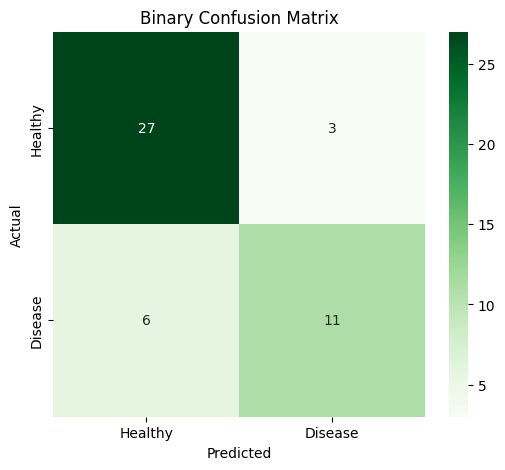


📄 Binary Classification Report:
              precision    recall  f1-score   support

     Healthy      0.818     0.900     0.857        30
     Disease      0.786     0.647     0.710        17

    accuracy                          0.809        47
   macro avg      0.802     0.774     0.783        47
weighted avg      0.806     0.809     0.804        47



In [ ]:
from pyspark.sql.functions import when, col
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#  1. تبدیل label به باینری: 0 = سالم، 1 = بیمار
binary_df = df_final.withColumn("binary_label", when(col("label") == 0, 0).otherwise(1))

#  2. تقسیم داده‌ها بدون حذف هیچ‌چیز
train_data, test_data = binary_df.randomSplit([0.8, 0.2], seed=42)

#  3. مدل Random Forest باینری
rf = RandomForestClassifier(labelCol="binary_label", featuresCol="features", numTrees=100, maxDepth=8)
model = rf.fit(train_data)

#  4. پیش‌بینی
predictions = model.transform(test_data)
predictions.select("prediction", "binary_label").show(10)

#  5. ارزیابی با BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f" ROC AUC: {roc_auc:.4f}")

#  6. محاسبه معیارهای دقیق‌تر
y_true = predictions.select("binary_label").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Healthy", "Disease"], yticklabels=["Healthy", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Binary Confusion Matrix")
plt.show()

print("\n Binary Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Healthy", "Disease"], digits=3))


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       2.0|    2|
|       0.0|    0|
+----------+-----+
only showing top 10 rows

✅ Accuracy       : 0.5957
🎯 F1 Score       : 0.6011
🧭 Precision      : 0.6302
🧪 Recall         : 0.5957


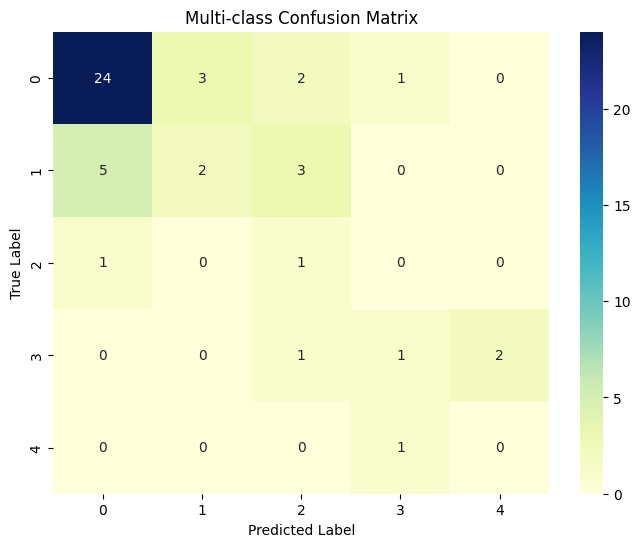


📄 Multi-class Classification Report:
              precision    recall  f1-score   support

           0      0.800     0.800     0.800        30
           1      0.400     0.200     0.267        10
           2      0.143     0.500     0.222         2
           3      0.333     0.250     0.286         4
           4      0.000     0.000     0.000         1

    accuracy                          0.596        47
   macro avg      0.335     0.350     0.315        47
weighted avg      0.630     0.596     0.601        47



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# 1. استفاده از تمام داده بدون حذف
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# 2. مدل Decision Tree برای چندکلاسه
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=8)
model = dt.fit(train_data)

# 3. پیش‌بینی
predictions = model.transform(test_data)
predictions.select("prediction", "label").show(10)

# 4. معیارهای ارزیابی
eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
eval_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

print(f" Accuracy       : {eval_acc.evaluate(predictions):.4f}")
print(f" F1 Score       : {eval_f1.evaluate(predictions):.4f}")
print(f" Precision      : {eval_prec.evaluate(predictions):.4f}")
print(f" Recall         : {eval_rec.evaluate(predictions):.4f}")

# 5. Confusion Matrix
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-class Confusion Matrix")
plt.show()

# 6. گزارش دقیق‌تر
print("\n Multi-class Classification Report:")
print(classification_report(y_true, y_pred, digits=3))


### XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:57:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Accuracy: 0.5833

 Classification Report:
              precision    recall  f1-score   support

           0      0.853     0.906     0.879        32
           1      0.222     0.364     0.276        11
           2      0.250     0.143     0.182         7
           3      0.333     0.143     0.200         7
           4      0.000     0.000     0.000         3

    accuracy                          0.583        60
   macro avg      0.332     0.311     0.307        60
weighted avg      0.564     0.583     0.564        60



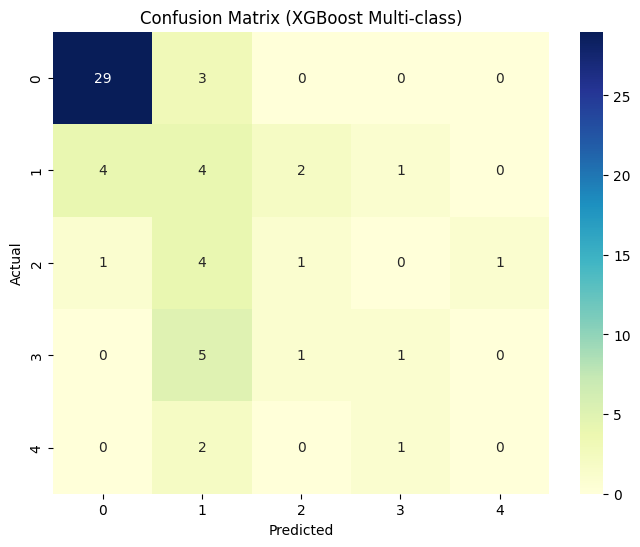

In [ ]:
# نصب XGBoost در Colab
!pip install -q xgboost

# 1. بارگذاری داده
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/heart_disease_uci.csv")

# 2. حذف ID و بررسی NA
df = df.drop(columns=["id"], errors="ignore")
df = df.dropna()

# 3. Label Encoding برای ستون‌های متنی
label_cols = df.select_dtypes(include="object").columns
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# 4. تعریف X و y
X = df.drop("num", axis=1)
y = df["num"]  # چندکلاسه: 0 تا 4

# 5. تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 6. مدل XGBoost
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1
)
model.fit(X_train, y_train)

# 7. پیش‌بینی و ارزیابی
y_pred = model.predict(X_test)
print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(" Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost Multi-class)")
plt.show()


### OverSample + class_weight

✅ Accuracy: 0.8000

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.812     0.812     0.812        32
           1      0.697     0.719     0.708        32
           2      0.857     0.750     0.800        32
           3      0.962     0.781     0.862        32
           4      0.732     0.938     0.822        32

    accuracy                          0.800       160
   macro avg      0.812     0.800     0.801       160
weighted avg      0.812     0.800     0.801       160



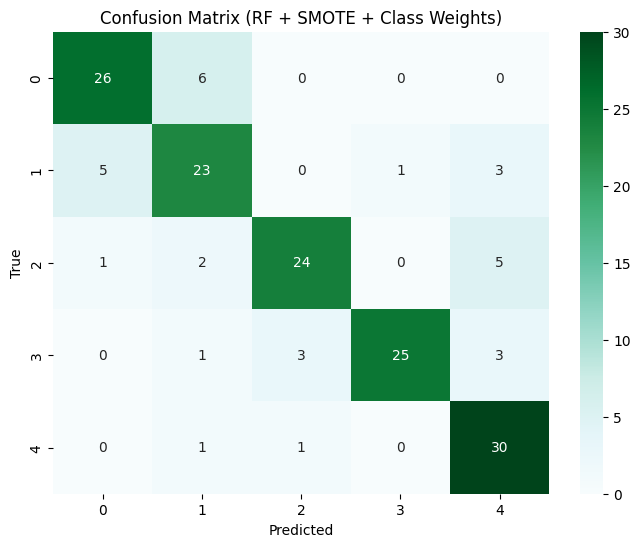

In [ ]:
!pip install -q imbalanced-learn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# بارگذاری داده
df = pd.read_csv("/content/heart_disease_uci.csv")
df = df.drop(columns=["id"], errors="ignore").dropna()

# Label Encoding
for col in df.select_dtypes("object").columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("num", axis=1)
y = df["num"]

# SMOTE روی کل داده
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# تقسیم train/test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# مدل جنگل تصادفی با وزن‌دهی خودکار
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=8, random_state=42)
rf.fit(X_train, y_train)

# ارزیابی
y_pred = rf.predict(X_test)
print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(" Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# ماتریس خطا
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (RF + SMOTE + Class Weights)")
plt.show()


# **2-**

# Extra Point

In [ ]:
!pkill -f Worker
!pkill -f Master

!rm -rf /content/spark-worker-1 /content/spark-worker-2


In [2]:
!/content/spark-3.1.2-bin-hadoop2.7/sbin/start-master.sh
!hostname


starting org.apache.spark.deploy.master.Master, logging to /content/spark-3.1.2-bin-hadoop2.7/logs/spark--org.apache.spark.deploy.master.Master-1-9a59076b2ff3.out
9a59076b2ff3


In [3]:
!nohup /content/spark-3.1.2-bin-hadoop2.7/sbin/start-worker.sh \
  --webui-port 8081 \
  --work-dir /content/spark-worker-1 \
  spark://f618f15ce7f4:7077 > /dev/null 2>&1 &

!nohup /content/spark-3.1.2-bin-hadoop2.7/sbin/start-worker.sh \
  --webui-port 8082 \
  --work-dir /content/spark-worker-2 \
  spark://f618f15ce7f4:7077 > /dev/null 2>&1 &


In [4]:
!jps

2337 Worker
2322 Jps
2236 Master
2300 Worker


In [5]:
!ls /content/spark-3.1.2-bin-hadoop2.7/logs/
!ps -ef | grep spark | grep Worker


spark--org.apache.spark.deploy.master.Master-1-9a59076b2ff3.out
spark--org.apache.spark.deploy.worker.Worker-1-9a59076b2ff3.out
spark--org.apache.spark.deploy.worker.Worker-1-9a59076b2ff3.out.1
root        2295    2294  0 12:52 ?        00:00:00 bash /content/spark-3.1.2-bin-hadoop2.7/sbin/spark-daemon.sh start org.apache.spark.deploy.worker.Worker 1 --webui-port 8081 --webui-port 8081 --work-dir /content/spark-worker-1 spark://f618f15ce7f4:7077
root        2300    2295 31 12:52 ?        00:00:00 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /content/spark-3.1.2-bin-hadoop2.7/conf/:/content/spark-3.1.2-bin-hadoop2.7/jars/* -Xmx1g org.apache.spark.deploy.worker.Worker --webui-port 8081 --webui-port 8081 --work-dir /content/spark-worker-1 spark://f618f15ce7f4:7077
root        2317    2312  0 12:52 ?        00:00:00 bash /content/spark-3.1.2-bin-hadoop2.7/sbin/spark-daemon.sh start org.apache.spark.deploy.worker.Worker 1 --webui-port 8081 --webui-port 8082 --work-dir /content/spark-worke

In [6]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# اتصال به Master در حالت Cluster
spark = SparkSession.builder \
    .appName("HeartDiseaseClassification") \
    .master("spark://9a59076b2ff3:7077") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .getOrCreate()


In [ ]:
df = spark.read.csv("/content/heart_disease_uci.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(how="any")  # حذف ردیف‌های ناقص

# حذف ستون‌های بی‌مصرف
df = df.drop("id", "dataset")

# ستون هدف (label)
label_col = "num"

# ستون‌های عددی (به جز label)
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# ستون‌های Boolean (True/False)
boolean_cols = ['fbs', 'exang']

# ستون‌های متنی که باید index بشن
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']

# StringIndexer برای ستون‌های متنی
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in categorical_cols]

# Index کردن ستون هدف (در صورت نیاز، ولی چون num عددیه، لازم نیست)
# اگر بخوای کلاس‌بندی باینری کنی (0 vs بقیه)، اینجا می‌تونی اون کارو بکنی

# تمام ویژگی‌ها نهایی برای مدل
final_features = numeric_cols + boolean_cols + [c + "_idx" for c in categorical_cols]

# بردارساز
assembler = VectorAssembler(inputCols=final_features, outputCol="features")

# Pipeline کامل
pipeline = Pipeline(stages=indexers + [assembler])
processed_df = pipeline.fit(df).transform(df).select("features", col(label_col).alias("label"))

# نمایش نمونه‌ای از داده نهایی
processed_df.show(5, truncate=False)


In [ ]:
train_data, test_data = processed_df.randomSplit([0.8, 0.2], seed=42)

# from pyspark.ml.classification import DecisionTreeClassifier
# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=10)


spark.sparkContext.setLogLevel("INFO")

model = rf.fit(train_data)


In [ ]:
print("Train Partitions:", train_data.rdd.getNumPartitions())
print("Test  Partitions:", test_data.rdd.getNumPartitions())


In [ ]:
train_data.rdd.map(lambda x: (x, spark.sparkContext._jvm.java.lang.Thread.currentThread().getName())).take(5)

In [ ]:
# نصب ngrok
!pip install -q pyngrok

# # اجرای Master (در پورت 8080)
# !/content/spark-3.1.2-bin-hadoop2.7/sbin/stop-master.sh
# !/content/spark-3.1.2-bin-hadoop2.7/sbin/start-master.sh

# پیدا کردن hostname برای Workerها
import subprocess
HOSTNAME = subprocess.check_output("hostname", shell=True).decode("utf-8").strip()

# # اجرای دو Worker با پورت‌های متفاوت و مسیر کار متفاوت
# !mkdir -p /content/spark-worker-1
# !mkdir -p /content/spark-worker-2
# !/content/spark-3.1.2-bin-hadoop2.7/sbin/start-worker.sh --webui-port 8081 --work-dir /content/spark-worker-1 spark://$HOSTNAME:7077
# !/content/spark-3.1.2-bin-hadoop2.7/sbin/start-worker.sh --webui-port 8082 --work-dir /content/spark-worker-2 spark://$HOSTNAME:7077

# اجرای ngrok برای پورت 8080 (Spark Master UI)
from pyngrok import ngrok

# بستن تونل‌های قبلی در صورت وجود
ngrok.kill()

# راه‌اندازی تونل برای پورت 8080
public_url = ngrok.connect(8080)
print(f" Spark Master UI Link: {public_url}")


In [ ]:
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)

print(f" Accuracy in Cluster Mode : {accuracy:.4f}")
print(f" F1 Score in Cluster Mode: {f1:.4f}")
print(f" Precision in Cluster Mode: {precision:.4f}")
print(f" Recall in Cluster Mode: {recall:.4f}")




 Accuracy in Cluster Mode : 0.5532
 F1 Score in Cluster Mode: 0.5176
 Precision in Cluster Mode: 0.5300
 Recall in Cluster Mode: 0.5532


با 2 کلاسه

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# حذف داده ناقص و ستون‌های بی‌مصرف
df = df.dropna(how="any")
df = df.drop("id", "dataset")

#  تبدیل به classification دوتایی: 0 = سلامت | 1 = بیمار
df = df.withColumn("label", when(col("num") == 0, 0).otherwise(1))

# تعیین ستون‌ها
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
boolean_cols = ['fbs', 'exang']
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']

# ساخت pipeline
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep") for c in categorical_cols]
final_features = numeric_cols + boolean_cols + [c + "_idx" for c in categorical_cols]
assembler = VectorAssembler(inputCols=final_features, outputCol="features")
pipeline = Pipeline(stages=indexers + [assembler])

# پردازش
processed_df = pipeline.fit(df).transform(df).select("features", "label")
train_data, test_data = processed_df.randomSplit([0.8, 0.2], seed=42)

#  مدل GBTClassifier (درخت تقویتی)
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100, maxDepth=5, stepSize=0.1, seed=42)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

#  ارزیابی
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_pre = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

print(" Accuracy       :", round(evaluator_acc.evaluate(predictions), 4))
print(" F1 Score       :", round(evaluator_f1.evaluate(predictions), 4))
print(" Precision      :", round(evaluator_pre.evaluate(predictions), 4))
print(" Recall         :", round(evaluator_rec.evaluate(predictions), 4))


 Accuracy       : 0.617
 F1 Score       : 0.6181
 Precision      : 0.6213
 Recall         : 0.617


اگمنتیشن

In [ ]:
from pyspark.sql.functions import rand
from pyspark.sql import DataFrame

# تابع oversample کردن کلاس هدف به مقدار دلخواه
def oversample(df: DataFrame, target_class: int, factor: int) -> DataFrame:
    small_df = df.filter(df.label == target_class)
    oversampled = small_df.sample(withReplacement=True, fraction=factor, seed=42)
    return oversampled

# شمارش کلاس‌ها
df_counts = processed_df.groupBy("label").count().orderBy("label")
df_counts.show()

# داده‌افزایی برای کلاس‌های با تعداد کم
augmented_dfs = [processed_df]  # شروع با کل دیتا
augmentation_factors = {1: 2.5, 2: 3.0, 3: 3.5}  # کلاس 0 نیازی نداره

for label, factor in augmentation_factors.items():
    augmented_dfs.append(oversample(processed_df, label, factor))

# تجمیع نهایی داده‌های افزوده شده
balanced_df = augmented_dfs[0]
for aug_df in augmented_dfs[1:]:
    balanced_df = balanced_df.union(aug_df)

# بررسی توازن نهایی
balanced_df.groupBy("label").count().orderBy("label").show()


from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# تقسیم آموزش و تست
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=42)

# مدل Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=150, maxDepth=10)
model = rf.fit(train_data)
predictions = model.transform(test_data)

# ارزیابی نهایی
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
acc = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f" Accuracy (Augmented)  : {acc:.4f}")
print(f" F1 Score (Augmented)  : {f1:.4f}")
print(f" Precision (Augmented) : {precision:.4f}")
print(f" Recall (Augmented)    : {recall:.4f}")


+-----+-----+
|label|count|
+-----+-----+
|    0|  160|
|    1|   56|
|    2|   35|
|    3|   35|
|    4|   13|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|  160|
|    1|  205|
|    2|  146|
|    3|  160|
|    4|   13|
+-----+-----+

 Accuracy (Augmented)  : 0.8915
 F1 Score (Augmented)  : 0.8763
 Precision (Augmented) : 0.8633
 Recall (Augmented)    : 0.8915
